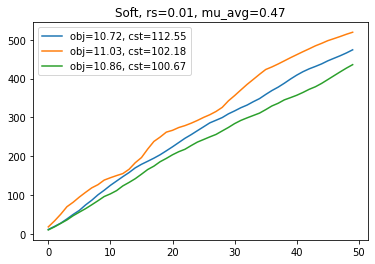

In [7]:
from functions import *


seed = 1
N = 3  # number of experiments
T = 50  # rounds per experiment
gamma = 2
rs = 0.01
alpha = 1

np.random.seed(seed)

m = 20 # number of devices
n = 15  # number of servers
y_max = 120
y_min = 80

wD = np.random.randint(1 ,4 ,m )
wS = np.random.randint(1 ,4 ,n )

BD = np.random.uniform(y_max * 0.1-3, y_max * 0.1+5, m)
BS = np.random.uniform(y_max * m / n - 100, y_max * m / n + 300, n)

CD = np.random.uniform(100, 200, m)


def f(x, y, mu, gamma=1):
    return objective(x, y, mu, wD, wS, m, n, gamma, alpha)

# min f(x, y. mu)
def oracle(y, mu, gamma=0, hard=False):
    x, prob = optimization(m, n, wD, wS, y, mu, BD, BS, gamma, hard, alpha, CD=CD)
    return x.value, prob.value, prob.status


reg = np.zeros((N, T))

# statistics
stats = np.zeros((N, T, 3))

#records all y, x_opt, x_t #yuhang yao
y_N_T = np.zeros((N, T, m)) #yuhang yao
x_opt_N_T = np.zeros((N, T, n + 1, m)) #yuhang yao
x_t_N_T = np.zeros((N, T, n + 1, m)) #yuhang yao
j_N_T = np.zeros((N, T, m))#yuhang yao

for u in range(N):
    mu = np.random.rand(m, n)
    # mu = trace_gen.avg()
    mu_hat = np.zeros_like(mu)  # empirical mean
    T_ij = np.ones_like(mu)  # total number of times arm (i,j) is played
    for t in range(T):
        y = np.random.uniform(y_min, y_max, m).astype(int)
        x_opt, f_opt, status = oracle(y, mu, gamma)

        if 'optimal' not in status:
            print('Solution infeasible 1')
            break

        fv, *_, dv, ev = f(x_opt, y, mu, gamma)
        stats[u, t] = np.array([fv, dv, ev])

        rho_ij = np.sqrt(3 * np.log(t + 1) / (2 * T_ij)) * rs
        mu_bar = np.clip(mu_hat - rho_ij, 0, None)  # LCB

        x_t, f_t, status = oracle(y, mu_bar, gamma)
        if 'optimal' not in status:
            print('Solution infeasible 2')
            break
        f_t, *_ = f(x_t, y, mu, gamma)

        # sample j based on x_t[i], observe c_ij, update mu_hat[i,j]
        # c = trace_gen.generate()
        for i in range(m):
            j = np.random.choice(n + 1, p=x_t[:, i])
            j_N_T[u, t, i] = j
            
            if j != 0:
                j -= 1
                c_ij = int(np.random.rand() < mu[i, j])
                # a = np.random.rand() * 3
                # c_ij = np.random.beta(a, a * (1-mu[i, j])/mu[i, j]) # beta distribution
                # c_ij = c[i,j] #trace

                T_ij[i, j] += 1
                mu_hat[i, j] += (c_ij - mu_hat[i, j]) / T_ij[i, j]

        # calculate regert
        reg[u, t] = f_t - f_opt
        
        y_N_T[u, t] = y#yuhang yao
        x_opt_N_T[u, t] = x_opt#yuhang yao
        x_t_N_T[u, t] = x_t#yuhang yao
        

plt.plot(np.cumsum(reg, axis=1).T)
f_avg = np.average(stats[:,:,0], 1)
obj_avg = np.average(stats[:,:,1], 1)
cons_avg = np.average(stats[:,:,2], 1)
legend = []
for i in range(N):
    legend.append('obj=%.2f, cst=%.2f' %(obj_avg[i], cons_avg[i]))
plt.legend(legend)
plt.title('Soft, rs=%.2f, mu_avg=%.2f' %(rs, np.average(mu)))
plt.show()


j_N_T = j_N_T.astype(int)

#yuhang yao
Data_num_D_N_T = np.zeros((N, T, wD.shape[0]))
Data_num_S_N_T = np.zeros((N, T, wS.shape[0]))
for u in range(N):
    for t in range(T):
        Data_num_S_N_T[u, t] = wS
        Data_num_D_N_T[u, t] = wD
        for i in range(m):
            
                    j = j_N_T[u, t, i]#np.random.choice(n + 1, p=x_t_N_T[u, t, :, i])
                    
                    if j != 0:
                        j -= 1
                        Data_num_S_N_T[u, t, j] += y_N_T[u, t, i] #upload to device j-1
                    else:
                        Data_num_D_N_T[u, t, i] += y_N_T[u, t, i] #stay in local device








In [ ]:
from fed_train import fed_T
import time
save_time = str(time.time())
for u in range(N):
    L_T = []
    for t in range(T):
        L = list(Data_num_D_N_T[u, t]) + list(Data_num_S_N_T[u, t])
        L_T.append(L)
    L_T = np.array(L_T).astype(int)



    loss_train, args = fed_T(L_T, "mnist")




    # plot loss curve
    plt.figure()
    plt.plot(range(len(loss_train)), loss_train)
    plt.ylabel('train_loss')
    plt.savefig('./save/' + save_time +'_' +str(u)+'_' + 'fed_{}_{}_{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.iid))

/Users/yuhangya/Library/Python/3.8/lib/python/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/Users/yuhangya/Library/Python/3.8/lib/python/site-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


MLP(
  (layer_input): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden): Linear(in_features=200, out_features=10, bias=True)
)
Round   0, Average loss 1.360
Round   1, Average loss 0.970
Round   2, Average loss 0.787
Round   3, Average loss 0.626
Round   4, Average loss 0.518
Round   5, Average loss 0.366
Round   6, Average loss 0.444
Round   7, Average loss 0.313
Round   8, Average loss 0.345
Round   9, Average loss 0.292
Round  10, Average loss 0.262
Round  11, Average loss 0.293
Round  12, Average loss 0.260
Round  13, Average loss 0.266
Round  14, Average loss 0.289
Round  15, Average loss 0.239
Round  16, Average loss 0.259
Round  17, Average loss 0.231
Round  18, Average loss 0.294
Round  19, Average loss 0.257
Round  20, Average loss 0.208
Round  21, Average loss 0.233
Round  22, Average loss 0.233
Round  23, Average loss 0.211
Round  24, Average loss 0.193
Round  25, Average loss 0.204
Round  26, Av